# Processing

- Clusters detected keystrokes using kmeans
- Uses bigrams combined with kmeans clusters to construct an hmm to predict mappings of keystroaks to characters
- Has functionality for testing a variety of parameters easily, stored to the results folder
- Has functionality to test what presence of white noise will disrupt the algorithm

## Imports

In [18]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline
import pandas as pd
import numpy as np
import sys, os, time, datetime
import matplotlib.pyplot as plt


sys.path.append('libraries')
import signal_processing as spl 
import prediction_lib as pl
pl = reload(pl)
spl = reload(spl)

### Import everything while develloping 

In [19]:
import numpy as np
from bs4 import BeautifulSoup
from collections import Counter
import urllib
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors
import pandas as pd
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.linear_model import LogisticRegressionCV as LogRegCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.decomposition import PCA
from tqdm import tqdm
import sys
from scipy import optimize
from IPython import display
from collections import Counter
from sklearn.externals import joblib
from scipy.cluster.vq import kmeans2,vq, whiten
from sklearn.cluster import KMeans
from hmmlearn.hmm import MultinomialHMM
from python_speech_features import mfcc

##  Load in Signal DF

In [62]:
# Whether to load in previous results
load = True

# Name of csv file without .csv
name = 'LABELED_CHARACTER_INPUTS'

# input file csv from preprocessing
INPUT_FILE = 'data/%s.csv' % name

# Output filename for results
out_name = 'results/%s_RESULTS.csv' % name

### Load in previous results to append to

In [63]:
if load and os.path.exists(out_name):
    RESULTS_DF = pd.read_csv(out_name, index_col = 0)
    RESULTS_DF.head()
else:
    RESULTS_DF = None

,ACCURACY_WO_SPACES,DO_ALL,INPUT_FILE,MAX_COLS,MFCC_END,MFCC_START,MODEL,MODEL_FNAME,NUM_CLUSTERS,N_COMPONENTS,OVERALL_ACCURACY,PREDICTION,RATE,SCORE,SMOOTH,TOL,WHITEN
2016-12-02 17:04:58.700675,0.482840,True,data/LABELED_CHARACTER_INPUTS.csv,-1,-60,0,"MultinomialHMM(algorithm='viterbi', init_param...",models/2016-12-02 17:04:58.700675-0.5684410646...,50,100.0,0.568441,alice sas helingang to fed beco soved ly witth...,44100,-3820.143368,0.135335,0.01,True
2016-12-02 17:13:51.388016,0.473373,True,data/LABELED_CHARACTER_INPUTS.csv,-1,-60,0,"MultinomialHMM(algorithm='viterbi', init_param...",models/2016-12-02 17:13:51.388016-0.5627376425...,40,100.0,0.562738,alice wad hedithing to jed bere theed ly withi...,44100,-3696.973774,0.135335,0.01,True
2016-12-02 17:36:26.673856,0.474556,True,data/LABELED_CHARACTER_INPUTS.csv,-1,-60,0,"MultinomialHMM(algorithm='viterbi', init_param...",models/2016-12-02 17:36:26.673856-0.5598859315...,50,100.0,0.559886,allke sas hedingang fo sen bend theed be wicea...,44100,-3808.791942,20.085537,0.01,True
2016-12-02 17:36:18.340493,0.473373,True,data/LABELED_CHARACTER_INPUTS.csv,-1,-60,0,"MultinomialHMM(algorithm='viterbi', init_param...",models/2016-12-02 17:36:18.340493-0.5589353612...,50,100.0,0.558935,allke sas hedongang fo sen bend theed be wimea...,44100,-3805.940816,7.389056,0.01,True
2016-12-02 17:18:29.780474,0.465089,True,data/LABELED_CHARACTER_INPUTS.csv,-1,-60,0,"MultinomialHMM(algorithm='viterbi', init_param...",models/2016-12-02 17:18:29.780474-0.5570342205...,40,100.0,0.557034,alime was hexinting ce bed oury ticed be wicck...,44100,-3660.052002,0.135335,0.01,True


## Read in input signals and clean up

In [64]:
char_inps_raw = pd.read_csv(INPUT_FILE, index_col=0)
char_inps_raw['char'] = char_inps_raw['char'].fillna(' ').replace('#SPACE', ' ')
# char_inps_raw['peak_diff'] =char_inps_raw['peak_diff'].fillna(0)
char_inps_raw = char_inps_raw.fillna(0)
char_inps_raw.tail(5)

,index,peak time,signal,start time,end time,char,is_space,peak_diff,0,1,...,16791,16792,16793,16794,16795,16796,16797,16798,16799,16800
1047,1091,599.006667,6431.091797,598.971667,599.321667,h,0,0.247333,-3.0,-1.0,...,13.0,3.0,-6.0,17.0,10.0,-15.0,2.0,24.0,23.0,28.0
1048,1092,599.254000,3091.520508,599.219000,599.569000,o,0,0.462000,13.0,11.0,...,50.0,41.0,34.0,32.0,28.0,21.0,16.0,13.0,10.0,8.0
1049,1093,599.716000,913.455261,599.681000,600.031000,l,0,0.270667,2.0,4.0,...,40.0,-36.0,-24.0,100.0,-11.0,-66.0,54.0,46.0,41.0,33.0
1050,1094,599.986667,17315.521484,599.951667,600.301667,e,0,0.200667,-13.0,-19.0,...,-17.0,-140.0,-119.0,0.0,59.0,63.0,87.0,89.0,61.0,-7.0
1051,1095,600.187333,5176.197266,600.152333,600.502333,,0,0.000000,-18.0,-13.0,...,-12.0,-11.0,-7.0,-4.0,1.0,8.0,5.0,-1.0,2.0,6.0


## Detemine the target sequence

In [65]:
targ_s = ''.join(char_inps_raw['char'].values)
targ_s

'alice was beginning to get very tired of sitting by her sister on the bank and having nothing to do once or twice she had peeped into the book her sister was reading but it had no pictures or conversations in it and what is the use of a book thought alice without pictures or conversations so she was considering in her own mind a well as she could for the hot day made her feel very sleepy and stupid whether the pleasure of making a daisy chain would be worth the trouble of getting up and picking the daisies when suddenly a white rabbit with pink eyes ran close by her there was nothing so very emarkable in that nor did alice think it so very much oh dear i shall be late it occurred to her afterwards she ought to have wondered at this but at the time it all seemed quite natural but when the rabbit actually toook a watch out of its packet and looked at it and then hurried on alice started to her feet and in another moment down went alice after it never once considering burning how in the 

## Reinitialize local parameter diction

In [66]:
PARAM_RESULTS ={}

## Processing 

In [28]:
# Rate of the input file
RATE = 44100

# Whether or not to whiten the data
WHITEN = True

# IF a model performs better than this, save it to file
SAVE_THRESH= 0.45

# The change required to stop training hmm
TOL = 1e-2

# Whether or not to loop through parameters in next cell
should_loop = False

# The maximum column to use for the raw signals
MAX_COLS = -1

# The start indices to test for the mfcc features
MFCC_START = [0]

# The end indicies to test for the fmcc features
MFCC_END = [-60]

# The number if k means clusters to use
NUM_CLUSTERS = [50]

# THe number of pca components to use, None for no pca
N_COMPONENTS = [100]

# Whether or not to load in actual labeled frequencies into the emission matrix for every 
# key rather than just the spaces
DO_ALL = False

# Number of times to repeat hmm model for parameters
REPEATS = 24

# The smoothing parameters to test 
SMOOTHS = map(lambda x : np.exp(x), range(-2,2))

In [29]:
def build_params(smooth, end, start, cluster, comp):
    '''
        Function creates new entry in parameter results 
        
        this dictionary keeps track of what parameters are used for each
        test run, and what the value/model ended up being
    '''
    _id = datetime.datetime.now()
    PARAM_RESULTS[_id] = {'RATE' : RATE,
        'TOL' : TOL,
        'INPUT_FILE' : INPUT_FILE,
         'MAX_COLS': MAX_COLS,
          'NUM_CLUSTERS' : cluster,
          'N_COMPONENTS' : comp,
          'MFCC_START' : start,
          'MFCC_END' : end,
          'WHITEN' : WHITEN,
          'DO_ALL' : DO_ALL,
          'SMOOTH' : smooth,
          'PREDICTION' : None,
          'ACCURACY_WO_SPACES' : None,
         'OVERALL_ACCURACY' : None,
         'SCORE' : None,
         'MODEL' : None,
        'MODEL_FNAME' : None
                          
         }
    return PARAM_RESULTS[_id], _id

def save(model = None, accuracy = None, _id = None, verbose = False):
    '''
        Function when called saves the PARAM_RESULTS to file 
    '''
    global RESULTS_DF
    
    # Save the model to file if passed in
    if model:
        PARAM_RESULTS[_id]['MODEL_FNAME'] = "models/%s-%s.pkl" % (_id, accuracy)
        joblib.dump(model, "models/%s-%s.pkl" % (_id, accuracy))
    
    # Append on PARAM_RESULTS or create a new dataframe
    if RESULTS_DF is not None:
        RESULTS_DF = RESULTS_DF.append(pd.DataFrame(PARAM_RESULTS).T).drop_duplicates()
    else:
        RESULTS_DF = pd.DataFrame(PARAM_RESULTS).T
    
    # Sort results by accuracy and display to file
    RESULTS_DF.sort_values(['OVERALL_ACCURACY', 'ACCURACY_WO_SPACES'], ascending=False).to_csv(out_name)
    
    if verbose:
        by_smooth = RESULTS_DF[['ACCURACY_WO_SPACES','OVERALL_ACCURACY', 'SMOOTH']].dropna().astype(float).groupby('SMOOTH')
        print 'max'
        display.display(by_smooth.max().sort_values(['OVERALL_ACCURACY', 'ACCURACY_WO_SPACES'], ascending =False).head(3))
        print 'mean'
        display.display(by_smooth.mean().sort_values(['OVERALL_ACCURACY', 'ACCURACY_WO_SPACES'], ascending =False).head(3))
        print 'var'
        display.display(by_smooth.var().sort_values(['OVERALL_ACCURACY', 'ACCURACY_WO_SPACES'], ascending =False).head(3))


def loop():
    '''
        Loops through and tests each parameter, saves results to dictionary and file
    '''
    
    # Copy and take subset
    char_inps = char_inps_raw[char_inps_raw.columns[:MAX_COLS]].copy()
    
    for _ in range(REPEATS):
        # Extract features
        for end in MFCC_END:
            for start in MFCC_START:
                for cluster in NUM_CLUSTERS:
                    for comp in N_COMPONENTS:
                        cepstrum_df = pl.extract_cepstrum(char_inps, RATE, mfcc_start=start, mfcc_end=end)

                        # Cluster the sounds
                        cepstrum_df = pl.cluster(cepstrum_df, num_clusters = cluster, n_components = comp)

                        # Repeat the hmm experiement for each parameter

                        # For each smoothing parameter to be tested
                        for smooth in SMOOTHS:


                            estimate, acc, acc_wospace, score, hmm = pl.run_hmm(cepstrum_df, targ_s, 
                                                                    cluster, t_smooth = smooth, tol = TOL,
                                                                    do_all = DO_ALL, verbose = False)  
                            print smooth, acc, acc_wospace, score
                            params,_id = build_params(smooth, end, start, cluster, comp)
                            
                            # Save values
                            params['OVERALL_ACCURACY'] = acc
                            params['ACCURACY_WO_SPACES'] = acc_wospace
                            params['PREDICTION'] = estimate
                            params['SCORE'] = score
                            params['MODEL'] = hmm

                            if acc > SAVE_THRESH:
                                save(hmm, acc, _id)
                            else:
                                save()
if should_loop:
    loop()

In [30]:
save()

# Visualizing process 

In [31]:
char_inps = char_inps_raw.copy()
char_inps = char_inps_raw[char_inps_raw.columns[:MAX_COLS]].copy()
char_inps.tail(10)

,index,peak time,signal,start time,end time,char,is_space,peak_diff,0,1,...,16790,16791,16792,16793,16794,16795,16796,16797,16798,16799
1042,1086,596.346667,12875.447266,596.311667,596.661667,b,0,0.270667,18.0,20.0,...,16.0,98.0,98.0,-60.0,-27.0,88.0,85.0,46.0,-21.0,-80.0
1043,1087,596.617333,22127.296875,596.582333,596.932333,b,0,0.149333,17.0,13.0,...,8.0,9.0,7.0,6.0,10.0,11.0,10.0,10.0,11.0,9.0
1044,1088,596.766667,2168.157959,596.731667,597.081667,i,0,0.354667,-5.0,4.0,...,-11.0,-14.0,-16.0,-17.0,-13.0,-13.0,-21.0,-21.0,-14.0,-14.0
1045,1089,597.121333,1214.426758,597.086333,597.436333,t,0,0.294000,26.0,26.0,...,-104.0,48.0,243.0,253.0,147.0,56.0,-3.0,99.0,157.0,53.0
1046,1090,597.415333,25453.357422,597.380333,597.730333,,1,1.591333,10.0,6.0,...,-13.0,-15.0,-15.0,-17.0,-25.0,-28.0,-21.0,-17.0,-21.0,-24.0
1047,1091,599.006667,6431.091797,598.971667,599.321667,h,0,0.247333,-3.0,-1.0,...,-9.0,13.0,3.0,-6.0,17.0,10.0,-15.0,2.0,24.0,23.0
1048,1092,599.254000,3091.520508,599.219000,599.569000,o,0,0.462000,13.0,11.0,...,51.0,50.0,41.0,34.0,32.0,28.0,21.0,16.0,13.0,10.0
1049,1093,599.716000,913.455261,599.681000,600.031000,l,0,0.270667,2.0,4.0,...,-51.0,40.0,-36.0,-24.0,100.0,-11.0,-66.0,54.0,46.0,41.0
1050,1094,599.986667,17315.521484,599.951667,600.301667,e,0,0.200667,-13.0,-19.0,...,120.0,-17.0,-140.0,-119.0,0.0,59.0,63.0,87.0,89.0,61.0
1051,1095,600.187333,5176.197266,600.152333,600.502333,,0,0.000000,-18.0,-13.0,...,-10.0,-12.0,-11.0,-7.0,-4.0,1.0,8.0,5.0,-1.0,2.0


## Visualize Spaces 

Visualizing:  


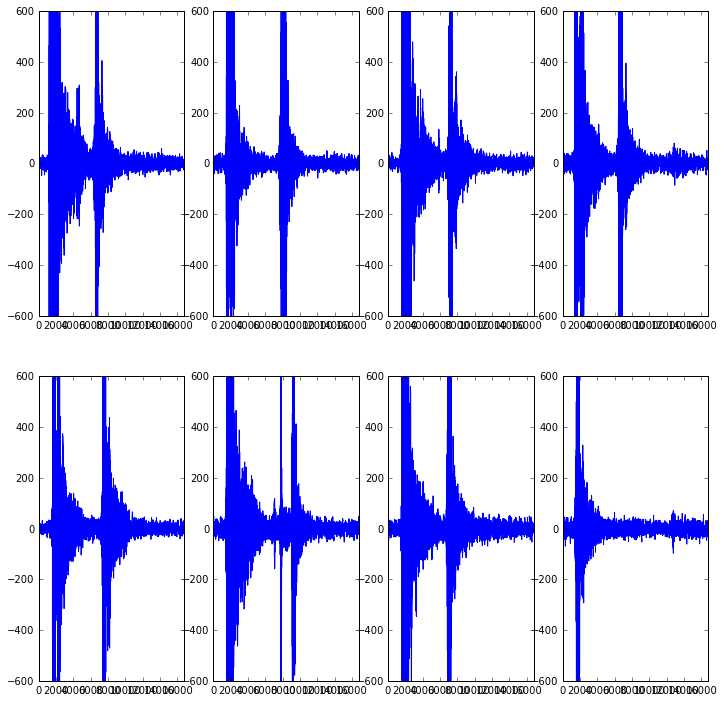

In [32]:
pl.view_char(char_inps, ' ', limit = 8, xlim = 600)

Visualizing: e


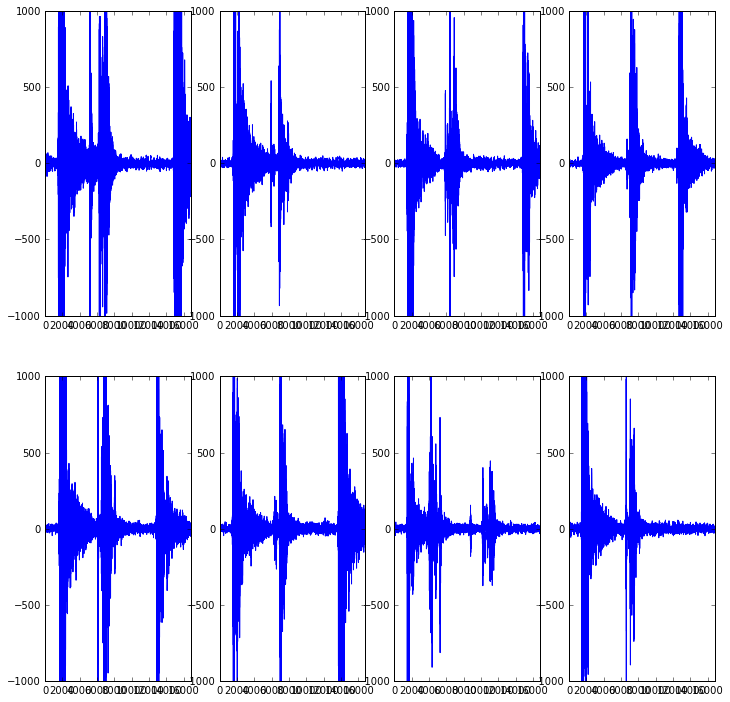

In [33]:
pl.view_char(char_inps, 'e', limit = 8, xlim = 1000)

## Get the cepstrum features from the raw signal 

In [36]:
 # Extract features
cepstrum_df = pl.extract_cepstrum(char_inps, RATE, mfcc_start=MFCC_START[0], mfcc_end=MFCC_END[0])

cepstrum_df.head()

,char,0,1,2,3,4,5,6,7,8,...,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439
0,a,7.360694,-18.524771,-2.092398,3.143520,-10.723268,-3.549318,-0.282734,14.213113,9.274911,...,-1.683619,5.277322,0.287023,5.626639,-3.095632,-22.771209,12.799282,9.088336,3.117657,1.135520
1,l,8.473535,-9.863563,3.092308,3.186686,-9.089651,-4.812348,-0.150097,1.828356,-10.408069,...,-8.176014,-2.032015,-5.763435,-1.215419,-11.340812,3.421349,-7.678221,-15.881190,4.662345,-2.214626
2,i,8.499915,-6.606512,6.164539,-0.447946,-10.593182,-6.919354,-6.139018,7.220757,-17.217173,...,-2.713296,-8.869842,-12.053295,-6.171257,9.205084,0.960087,13.822375,1.063057,-18.493161,-11.907804
3,c,8.131859,-14.015240,-2.558620,-1.912657,-9.440824,-10.006736,-0.196319,2.987380,-1.112386,...,7.898394,18.332908,1.280099,-16.928093,-2.456783,-4.005894,1.342468,-8.401993,-7.762280,-0.178588
4,e,11.682435,-27.831874,6.046867,2.681784,-9.937450,-0.475957,8.945243,-17.051892,12.227313,...,-7.967790,9.277884,-13.117242,-9.112559,-5.433476,-5.749577,10.962522,0.652460,-6.015502,-2.487312


## Check the PCA variance

In [38]:
inds = cepstrum_df.dtypes == np.float64
data = cepstrum_df.ix[:,inds].values
# Standardize data
if WHITEN:
    data = whiten(data)
        
pca = PCA(n_components=N_COMPONENTS[0])
pca.fit(data)
data = pca.transform(data)
pca.explained_variance_ratio_.sum()

PCA(copy=True, n_components=100, whiten=False)

0.61133853892673706

## Visualize Cepstrum Features 

Visualizing:  


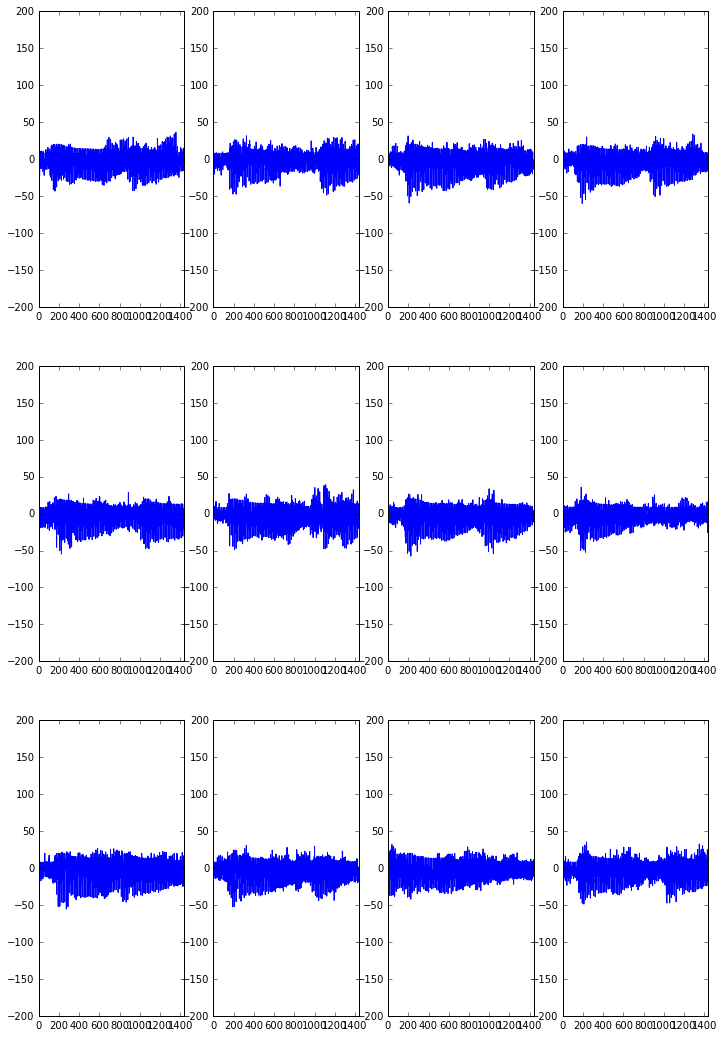

In [39]:
pl.view_char(cepstrum_df, ' ', xlim = 200, limit = 12)

Visualizing: e


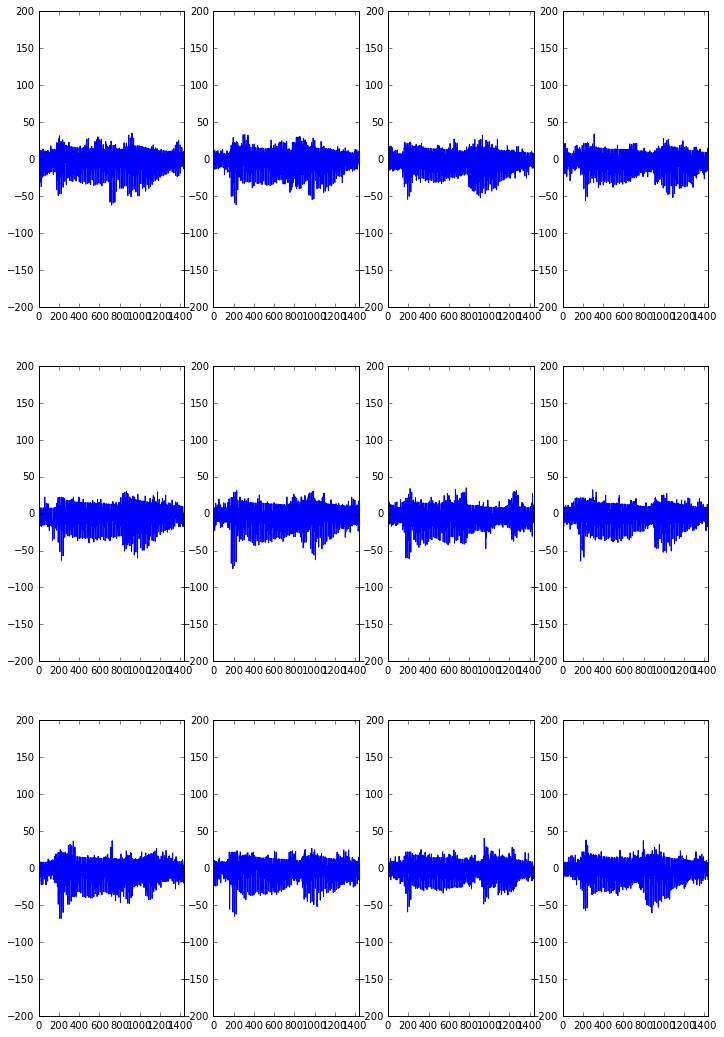

In [40]:
pl.view_char(cepstrum_df, 'e', xlim = 200, limit = 12)

## Cluster the features

In [41]:
# Cluster the sounds
cepstrum_df = pl.cluster(cepstrum_df, num_clusters = NUM_CLUSTERS[0], n_components = N_COMPONENTS[0])
cepstrum_df.head()

,char,0,1,2,3,4,5,6,7,8,...,1431,1432,1433,1434,1435,1436,1437,1438,1439,cluster
0,a,7.360694,-18.524771,-2.092398,3.143520,-10.723268,-3.549318,-0.282734,14.213113,9.274911,...,5.277322,0.287023,5.626639,-3.095632,-22.771209,12.799282,9.088336,3.117657,1.135520,24
1,l,8.473535,-9.863563,3.092308,3.186686,-9.089651,-4.812348,-0.150097,1.828356,-10.408069,...,-2.032015,-5.763435,-1.215419,-11.340812,3.421349,-7.678221,-15.881190,4.662345,-2.214626,20
2,i,8.499915,-6.606512,6.164539,-0.447946,-10.593182,-6.919354,-6.139018,7.220757,-17.217173,...,-8.869842,-12.053295,-6.171257,9.205084,0.960087,13.822375,1.063057,-18.493161,-11.907804,28
3,c,8.131859,-14.015240,-2.558620,-1.912657,-9.440824,-10.006736,-0.196319,2.987380,-1.112386,...,18.332908,1.280099,-16.928093,-2.456783,-4.005894,1.342468,-8.401993,-7.762280,-0.178588,8
4,e,11.682435,-27.831874,6.046867,2.681784,-9.937450,-0.475957,8.945243,-17.051892,12.227313,...,9.277884,-13.117242,-9.112559,-5.433476,-5.749577,10.962522,0.652460,-6.015502,-2.487312,43


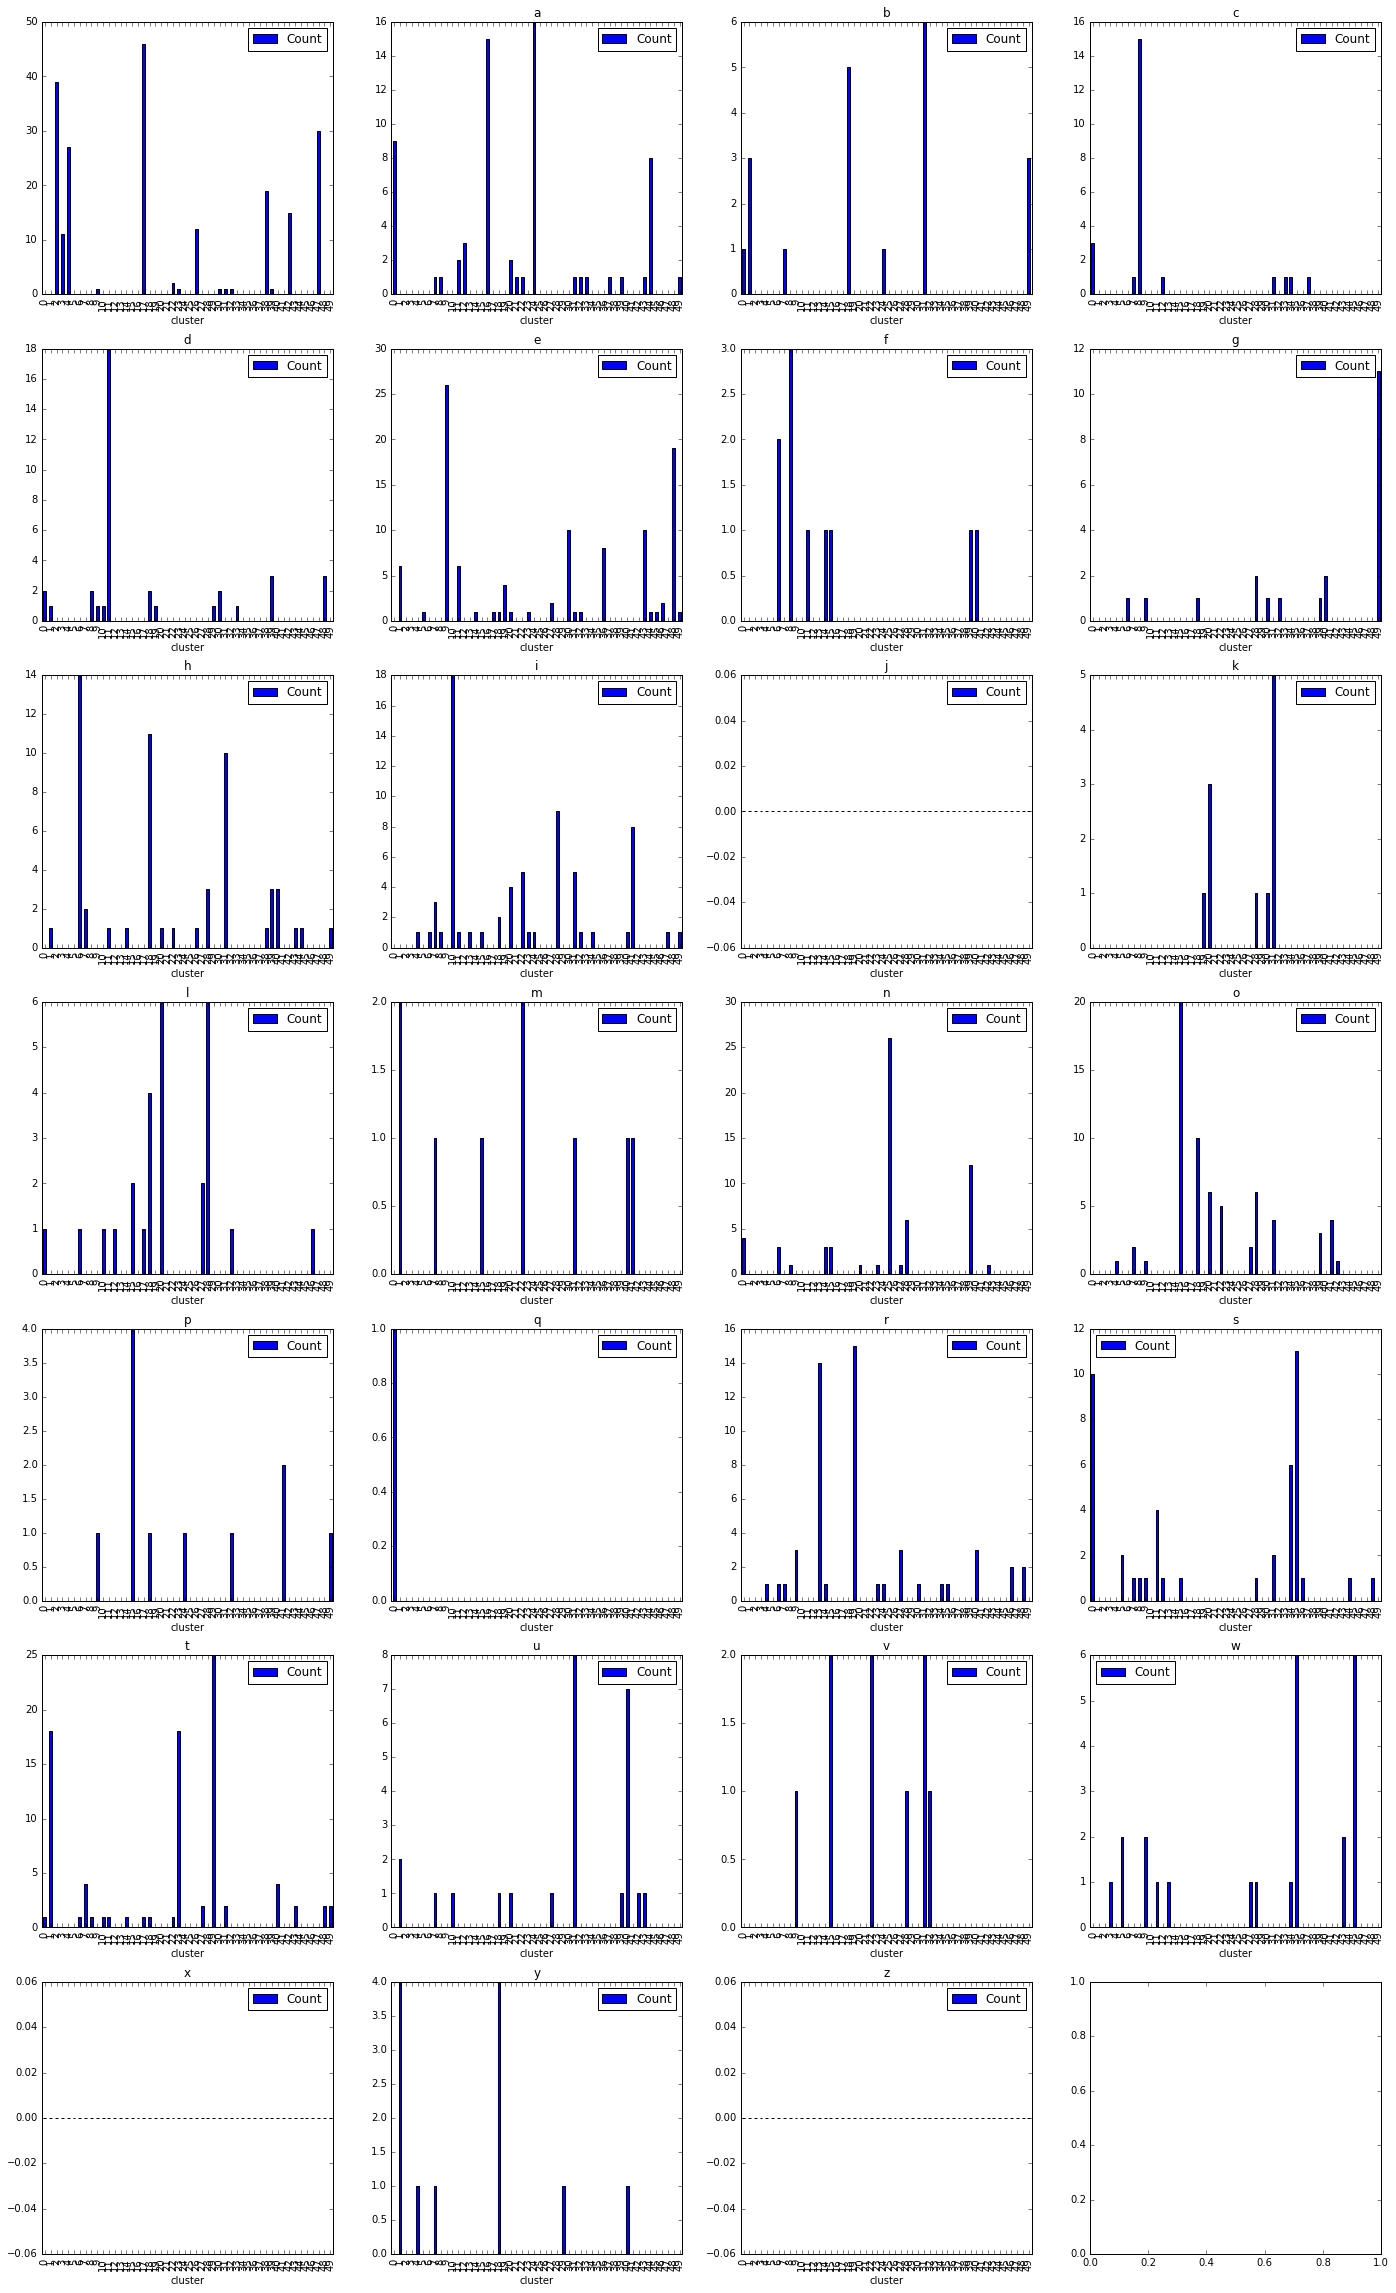

In [43]:
pl.cluster_proportions(cepstrum_df, [' '] + map(lambda x : chr(x + ord('a')),  range(26)), num_clusters = NUM_CLUSTERS[0])

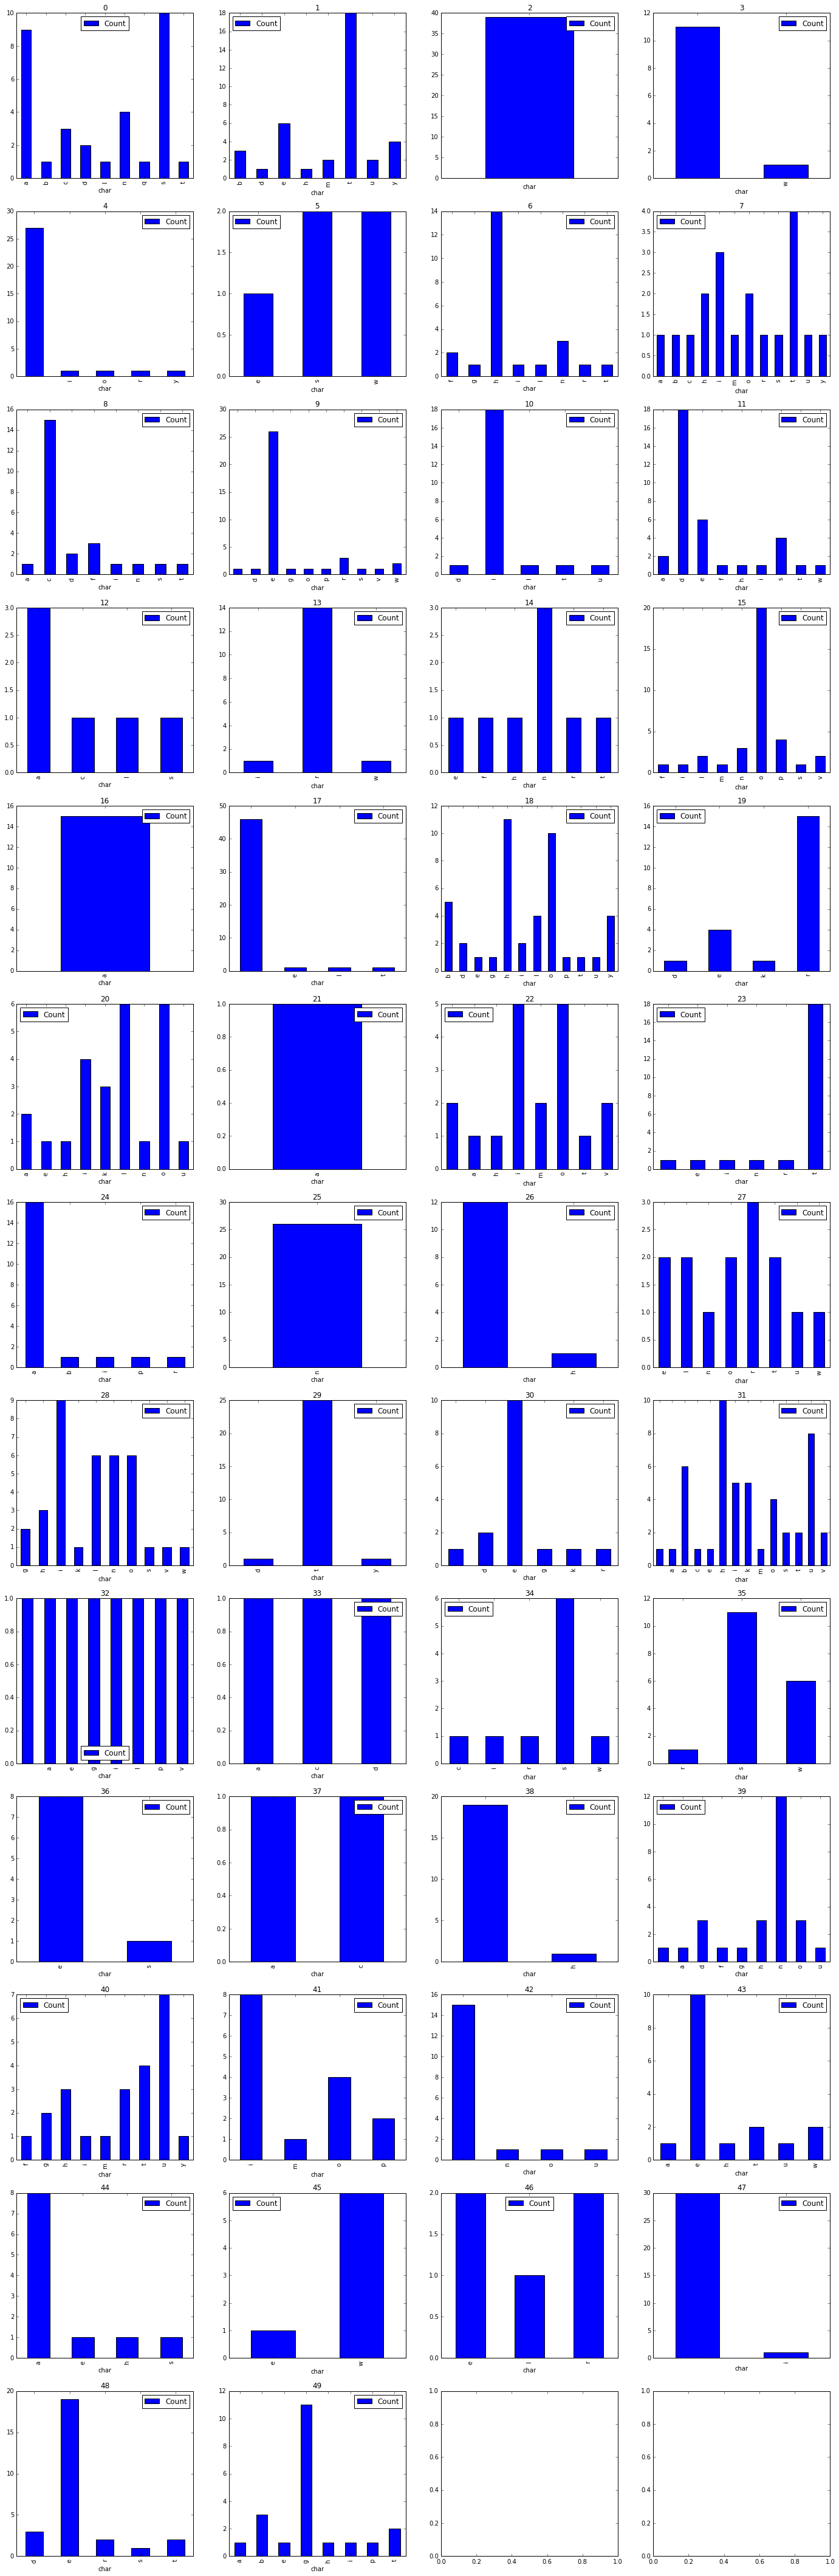

In [44]:
cepstrum_df['Count'] = 1
scores = cepstrum_df[['char', 'cluster', 'Count']].groupby(['cluster', 'char']).count()
n = NUM_CLUSTERS[0]
fig, axes = plt.subplots((n-1)/4+1, 4, figsize=(24, n*3/2))

# Repeat for each coefficient
for cl in range(n):
    axe = axes[cl / 4][cl % 4]
   
    _ = scores.ix[cl].plot(kind='bar', ax = axe)
    _ = axe.set_title(cl)

## Build Transmission Matrix with bigrams

In [45]:
pl = reload(pl)
A_df, n_unique, unique_chars, id_to_char, char_to_id  = pl.build_transmission_full()
A_df.head()

,,a,b,c,d,e,f,g,h,i,...,q,r,s,t,u,v,w,x,y,z
,0.000000,0.127255,0.035790,0.036607,0.032716,0.017157,0.030375,0.023058,0.055145,0.073120,...,0.006418,0.019598,0.089610,0.163405,0.010893,0.008894,0.070323,0.000203,0.021365,0.000068
a,0.075696,0.000101,0.024452,0.020636,0.048541,0.000202,0.007287,0.021922,0.002530,0.077155,...,0.000030,0.085984,0.095421,0.136734,0.008407,0.018004,0.008907,0.001215,0.029918,0.000506
b,0.007936,0.047051,0.038547,0.000000,0.000567,0.369802,0.000000,0.000000,0.000000,0.070459,...,0.000000,0.035146,0.017573,0.007369,0.136617,0.000000,0.000000,0.000000,0.057688,0.000000
c,0.016731,0.118680,0.000000,0.011810,0.000000,0.263393,0.000000,0.000000,0.174778,0.019027,...,0.000000,0.040776,0.000328,0.078194,0.037399,0.000000,0.000000,0.000000,0.002624,0.000000
d,0.627469,0.023523,0.001637,0.000000,0.012917,0.095696,0.001819,0.006004,0.000546,0.059470,...,0.000000,0.017102,0.016845,0.000000,0.013099,0.004366,0.000728,0.000000,0.008369,0.000000


##  Check the proportion of spaces across the k means classes

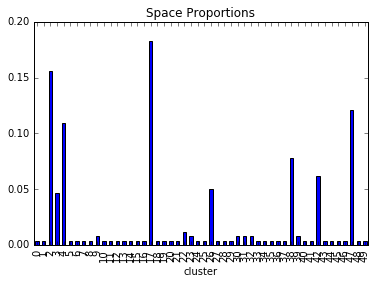

In [47]:
space_props= pl.get_props(cepstrum_df, NUM_CLUSTERS[0], ' ')
_  = space_props.plot(kind='bar', title = 'Space Proportions')

## Build emissions matrix

In [48]:
Eta = pl.build_eta(cepstrum_df, unique_chars, NUM_CLUSTERS[0], do_all = DO_ALL)
Eta


array([[  3.89105058e-03,   3.89105058e-03,   1.55642023e-01, ...,
          1.20622568e-01,   3.89105058e-03,   3.89105058e-03],
       [  2.68622273e-02,   3.46515760e-02,   3.35976268e-02, ...,
          1.08014360e-04,   3.27277211e-02,   2.88317928e-02],
       [  1.05608285e-02,   3.97526264e-02,   1.91280788e-02, ...,
          3.21317067e-02,   3.44526714e-02,   5.34862746e-03],
       ..., 
       [  1.94816254e-02,   2.13868883e-02,   4.02827735e-02, ...,
          3.17905615e-03,   2.59188625e-02,   3.06772454e-02],
       [  3.97374837e-02,   3.45967391e-02,   1.36689754e-02, ...,
          3.32595926e-02,   2.29147277e-03,   1.60183274e-02],
       [  1.99091835e-02,   1.06111552e-02,   5.52514144e-03, ...,
          7.53131523e-03,   3.24645725e-02,   2.85384412e-02]])

## Get Unigram proportions

In [61]:
char_counts = pl.get_char_counts(targ_s, unique_chars)
char_counts

TypeError: get_char_counts() takes no arguments (2 given)

## Run HMM

In [ ]:
smooth = 2.5
estimate, acc, acc_wospace, score, hmm = pl.run_hmm(cepstrum_df, targ_s, 
                                                    NUM_CLUSTERS[0], t_smooth = smooth, tol = TOL,
                                                    do_all = DO_ALL, verbose = False)  

params,_id = build_params(smooth, MFCC_START[0], MFCC_END[0], NUM_CLUSTERS[0], N_COMPONENTS[0])

params['OVERALL_ACCURACY'] = acc
params['ACCURACY_WO_SPACES'] = acc_wospace
params['PREDICTION'] = estimate
params['SCORE'] = score
params['MODEL'] = hmm

if acc > SAVE_THRESH:
    save(hmm, acc, _id)
else:
    save()

In [ ]:
estimate

In [59]:
targ_s

'alice was beginning to get very tired of sitting by her sister on the bank and having nothing to do once or twice she had peeped into the book her sister was reading but it had no pictures or conversations in it and what is the use of a book thought alice without pictures or conversations so she was considering in her own mind a well as she could for the hot day made her feel very sleepy and stupid whether the pleasure of making a daisy chain would be worth the trouble of getting up and picking the daisies when suddenly a white rabbit with pink eyes ran close by her there was nothing so very emarkable in that nor did alice think it so very much oh dear i shall be late it occurred to her afterwards she ought to have wondered at this but at the time it all seemed quite natural but when the rabbit actually toook a watch out of its packet and looked at it and then hurried on alice started to her feet and in another moment down went alice after it never once considering burning how in the 

In [60]:
smooths = map(lambda x : np.exp(x), range(-2, 4))
# smooths = np.arange(0,2,.1)
for smooth in smooths:
    estimate, acc, acc_wospace, score, hmm = pl.run_hmm(cepstrum_df, targ_s, 
                                                    NUM_CLUSTERS[0], t_smooth = smooth, tol = TOL,
                                                    do_all = DO_ALL, verbose = False)  
    params,_id = build_params(smooth, MFCC_START[0], MFCC_END[0], NUM_CLUSTERS[0], N_COMPONENTS[0])
    params['OVERALL_ACCURACY'] = acc
    params['ACCURACY_WO_SPACES'] = acc_wospace
    params['PREDICTION'] = estimate
    params['SCORE'] = score
    params['MODEL'] = hmm

    if acc > SAVE_THRESH:
        save(hmm, acc, _id)
    else:
        save()
    print smooth, acc, acc_wospace, score
    print estimate

0.135335283237 0.402091254753 0.279289940828 -3835.13825187
averersat ongurring to sed bico theed id butsthe he ren boutin or the wind and ashour n therg th se bere plilifre ire had qucain athe the some and pasan ceng llickng wad me wad bo oratlles wexpallid athout an it and alit st the abe ar w wove th cowe ckere qullowh owalasithed bonondis thethal the ait boowaisaind an wed ato mind d send as the pllid out she wos hio then wed hico medo aceng wing tllous whashen couzzzishaichof wimind t thadourojun wared se qully thicenojeve or willing wa and outhing whe d abung thin burkerof s chasilldghes quly oury oked lin ppese we hed thind the bothang se wind serandous in that cof ppe ioure thaly be ar wait serg of seand inive cke faly stherppllle to ind illinticks the athothes hain wonguthe it thad whe be cre sabe he ico theend asaly rilllid out tour the wagout icrkexpo thoow f shery lly pr ast arined ang ooover at ce aro ther senghed an thean teanden ly len llit ind al icathin athent iven lin

## For building audio files 

In [ ]:
# import sys
# import wave
# import math
# import struct
# import random
# import argparse
# from itertools import *

# def grouper(n, iterable, fillvalue=None):
#     "grouper(3, 'ABCDEFG', 'x') --> ABC DEF Gxx"
#     args = [iter(iterable)] * n
#     return izip_longest(fillvalue=fillvalue, *args)

# def sine_wave(frequency=440.0, framerate=44100, amplitude=0.5):
#     '''
#     Generate a sine wave at a given frequency of infinite length.
#     '''
#     period = int(framerate / frequency)
#     if amplitude > 1.0: amplitude = 1.0
#     if amplitude < 0.0: amplitude = 0.0
#     lookup_table = [float(amplitude) * math.sin(2.0*math.pi*float(frequency)*(float(i%period)/float(framerate))) for i in xrange(period)]
#     return (lookup_table[i%period] for i in count(0))

# def square_wave(frequency=440.0, framerate=44100, amplitude=0.5):
#     for s in sine_wave(frequency, framerate, amplitude):
#         if s > 0:
#             yield amplitude
#         elif s < 0:
#             yield -amplitude
#         else:
#             yield 0.0

# def damped_wave(frequency=440.0, framerate=44100, amplitude=0.5, length=44100):
#     if amplitude > 1.0: amplitude = 1.0
#     if amplitude < 0.0: amplitude = 0.0
#     return (math.exp(-(float(i%length)/float(framerate))) * s for i, s in enumerate(sine_wave(frequency, framerate, amplitude)))

# def white_noise(amplitude=0.9):
#     '''
#     Generate random samples.
#     '''
#     return (float(amplitude) * random.uniform(-1, 1) for i in count(0))

# def compute_samples(channels, nsamples=None):
#     '''
#     create a generator which computes the samples.

#     essentially it creates a sequence of the sum of each function in the channel
#     at each sample in the file for each channel.
#     '''
#     return islice(izip(*(imap(sum, izip(*channel)) for channel in channels)), nsamples)

# def write_wavefile(filename, samples, nframes=None, nchannels=2, sampwidth=2, framerate=44100, bufsize=2048):
#     "Write samples to a wavefile."
#     if nframes is None:
#         nframes = -1

#     w = wave.open(filename, 'w')
#     w.setparams((nchannels, sampwidth, framerate, nframes, 'NONE', 'not compressed'))

#     max_amplitude = float(int((2 ** (sampwidth * 8)) / 2) - 1)

#     # split the samples into chunks (to reduce memory consumption and improve performance)
#     for chunk in grouper(bufsize, samples):
#         frames = ''.join(''.join(struct.pack('h', int(max_amplitude * sample)) for sample in channels) for channels in chunk if channels is not None)
#         w.writeframesraw(frames)

#     w.close()

#     return filename

# def write_pcm(f, samples, sampwidth=2, framerate=44100, bufsize=2048):
#     "Write samples as raw PCM data."
#     max_amplitude = float(int((2 ** (sampwidth * 8)) / 2) - 1)

#     # split the samples into chunks (to reduce memory consumption and improve performance)
#     for chunk in grouper(bufsize, samples):
#         frames = ''.join(''.join(struct.pack('h', int(max_amplitude * sample)) for sample in channels) for channels in chunk if channels is not None)
#         f.write(frames)

#     f.close()

#     return filename

    
    
# frequency = 600.0
# frequency2 = 2000.0
# amplitude = 0.5
# achannels = 1
# bits = 16
# etime= 6

# # each channel is defined by infinite functions which are added to produce a sample.
# # channels = ((sine_wave(frequency,RATE, amplitude),) for i in range(achannels))

# # channels = ((sine_wave(frequency,RATE, amplitude),), (white_noise(amplitude=0.001),),
# #                 (sine_wave(frequency2,RATE, amplitude),), (white_noise(amplitude=0.001),))

# # channels = ((sine_wave(frequency,RATE, amplitude),), (white_noise(amplitude=0.1),),
# #                 (sine_wave(frequency2,RATE, amplitude),), (white_noise(amplitude=0.2),))

# channels = (( white_noise(amplitude=.1),) for i in range(achannels))

# # convert the channel functions into waveforms
# samples = compute_samples(channels, RATE * etime)

# # write the samples to a file
# filename = 'test.wav'

# write_wavefile(filename, samples, RATE * etime, achannels, bits / 8, RATE)

# IPython.display.Audio('test.wav', autoplay=True)